## Instructions to Install Visual Studio 2022 Community Edition

PyTorch relies heavily on C++ extensions for performance optimization. One of the fastest ways to ensure these dependencies are properly set up is to install **Visual Studio 2022 Community Edition**. Follow these steps to complete the installation:

1. **Download Visual Studio 2022 Community Edition**:
   - Use this [Visual Studio 2022 Community Edition](https://visualstudio.microsoft.com/vs/community/) to download the installer.

2. **Install the Visual Studio Installer**:
   - Run the `.exe` file that you downloaded.

3. **Install the Required C++ Components**:
   - During the installation, ensure you select the components for **Desktop development with C++**.
   
4. **Complete the Installation**:
   - Let the Visual Studio installer download and install the necessary files. This will set up the C++ toolchain, which PyTorch depends on.

Once this process is complete, your system will have the necessary C++ extensions to run PyTorch properly.


### Install the require libraries using pip command

In [1]:
# !pip install regex pandas scikit-learn numpy wordcloud matplotlib seaborn nltk gensim torch

### Importing libraries

In [2]:
import os
import re

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
base_dirt = os.getcwd()
path = os.path.join(base_dirt, 'dataset/p3_data.csv')
data = pd.read_csv(path, encoding='ISO-8859-1')

In [4]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


### Data explore

In [5]:
corpus = data[['OriginalTweet','Sentiment']]

In [6]:
corpus.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   OriginalTweet  41157 non-null  object
 1   Sentiment      41157 non-null  object
dtypes: object(2)
memory usage: 643.2+ KB


In [8]:
corpus.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [9]:
corpus['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [10]:
encoder = OrdinalEncoder(categories=[['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']])
corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])

C:\Users\tasnu\AppData\Local\Temp\ipykernel_8512\4240578442.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['Sentiment'] = encoder.fit_transform(corpus[['Sentiment']])


In [11]:
corpus['Sentiment'].value_counts()

Sentiment
3.0    11422
1.0     9917
2.0     7713
4.0     6624
0.0     5481
Name: count, dtype: int64

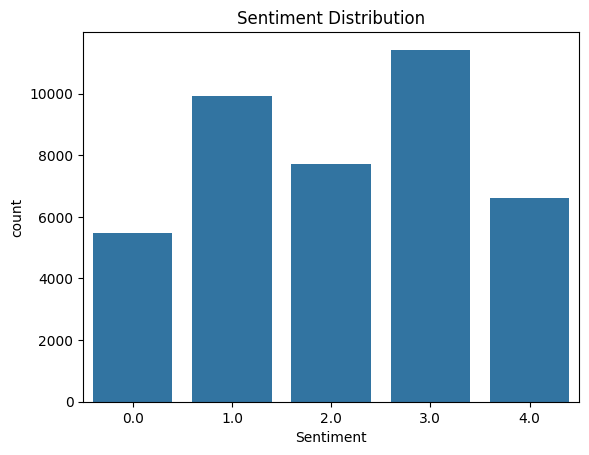

In [12]:
sns.countplot(x='Sentiment', data=corpus)
plt.title('Sentiment Distribution')
plt.show()

In [13]:
corpus['OriginalTweet'].sample(10).values

array(['WhatÂ\x92s the point of shopping online, especially for clothes when you arenÂ\x92t suppose to go out anywhere? \r\r\n\r\r\nYou have no where to show off your nice new clothes. \r\r\n\r\r\nBetter of saving your money ? and when this is all over, buy clothes or go on a extravagant vacation. #coronavirus',
       'Community bulletin from Countdown Supermarket 19',
       'Nurse in tears after 48-hour shift when she finds empty supermarket shelves #CoronaCrisisuk #CoronavirusPandemic #CoronaCrisisuk #coronavirusuk #CoronaVirusUpdate #Covid_19 #COVID19 #COVID?19 https://t.co/4ShNMslgCV',
       'Everyone has a small independent grocery store in town What s life for them during COVID 19  You get to be friends and do whatever you can to help each other out That s just the way it is you know via',
       "He's an asshole.\r\r\nA simple question to answer thoughtfully &amp; give a comforting response. \r\r\nI work in a grocery store &amp; people I encounter think everything is great, b

### Cleaning words sentences using regular expression

In [14]:
def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    
    return tweet

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


C:\Users\tasnu\AppData\Local\Temp\ipykernel_8512\2179563702.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(clean_tweet)


In [15]:
corpus['OriginalTweet'].sample(10).values

array(['The VTA has urged for patience as transport operators work overtime to respond to record consumer demand prompted by We salute the tremendous efforts of transport and supermarket workers during these challenging times',
       'Clever wont happen here though Supermarket In Denmark Uses Price Trick To Stop Sanitiser Hoarding via',
       'I commend your efforts so far in combating the COVID At this critical time families are greatly in need of cash to stock up food stuff I think you should consider paying NYSC members their earned arrears from April That will help',
       'Lets just assume that you have the virus if youre going into the grocery storeand save yourself some sanity I can only imagine the potential bacteria youre spreading by washing and disinfecting all your groceries',
       'People are becoming desperate in these toiletpaperless times',
       'Just went to Goodwins supermarket in Crestline My estimate is less than of the people in there were observing the sixf

### Removing Stopwords

In [16]:
corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()

C:\Users\tasnu\AppData\Local\Temp\ipykernel_8512\892715711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].str.lower()


In [17]:
nltk.download('stopwords')

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    new_text = []

    for word in words:
        if word not in stop_words:
            new_text.append(word)
    
    return ' '.join(new_text)

corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\tasnu\AppData\Local\Temp\ipykernel_8512\2800391941.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['OriginalTweet'] = corpus['OriginalTweet'].apply(remove_stop_words)


### WordCloud Visualization

In [18]:
def get_words(df, sentiment, n=10):
    sentiment_df = df[df['Sentiment'] == sentiment]

    all_words = []
    for tokens in sentiment_df['OriginalTweet']:
        for word in tokens.split():
            all_words.append(word)

    top_words = Counter(all_words).most_common(n)
    return dict(top_words)

positive_words = get_words(corpus, 3.0 , 10)
negative_words = get_words(corpus, 1.0, 10)
neutral_words = get_words(corpus, 2.0, 10)
extremely_positive_words = get_words(corpus, 4.0, 10)
extremely_negative_words = get_words(corpus, 0.0, 10)

print("Top 10 Extremely Positive Words:", extremely_positive_words)
print("Top 10 Positive Words:", positive_words)
print("Top 10 Neutral Words:", neutral_words)
print("Top 10 Negative Words:", negative_words)
print("Top 10 Extremely Negative Words:", extremely_negative_words)

Top 10 Extremely Positive Words: {'covid': 1655, 'store': 1258, 'amp': 1123, 'grocery': 1053, 'supermarket': 1032, 'help': 972, 'food': 961, 'hand': 938, 'prices': 931, 'sanitizer': 833}
Top 10 Positive Words: {'covid': 2933, 'store': 2014, 'prices': 2014, 'grocery': 1868, 'supermarket': 1814, 'food': 1718, 'people': 1429, 'amp': 1421, 'consumer': 1241, 'online': 1057}
Top 10 Neutral Words: {'covid': 1742, 'store': 1304, 'supermarket': 1241, 'prices': 1191, 'grocery': 1122, 'consumer': 904, 'shopping': 678, 'online': 666, 'food': 609, 'people': 599}
Top 10 Negative Words: {'covid': 2613, 'prices': 2350, 'food': 1941, 'supermarket': 1644, 'store': 1519, 'people': 1412, 'grocery': 1384, 'amp': 1078, 'consumer': 913, 'demand': 881}
Top 10 Extremely Negative Words: {'covid': 1539, 'food': 1531, 'prices': 1335, 'people': 1212, 'panic': 1137, 'supermarket': 902, 'crisis': 833, 'amp': 827, 'store': 662, 'buying': 646}


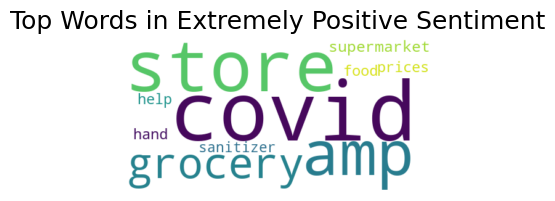

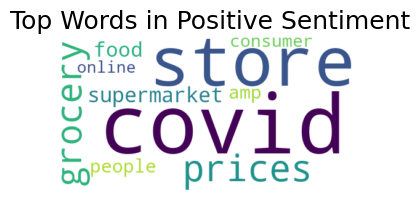

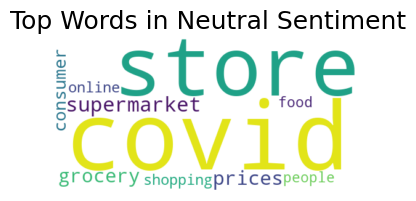

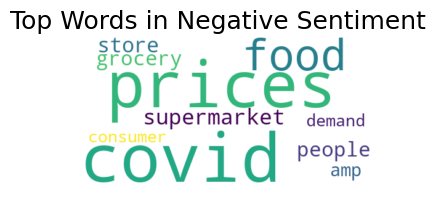

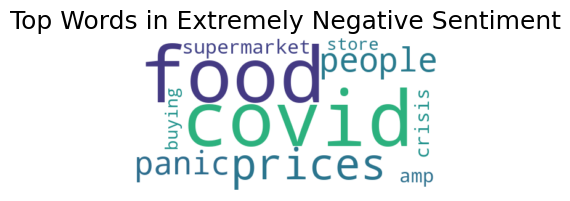

In [19]:
def plot_wordcloud(word_freq, title):
    wordcloud = WordCloud(width=500, height=250, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(4, 2))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(extremely_positive_words, 'Top Words in Extremely Positive Sentiment')
plot_wordcloud(positive_words, 'Top Words in Positive Sentiment')
plot_wordcloud(neutral_words, 'Top Words in Neutral Sentiment')
plot_wordcloud(negative_words, 'Top Words in Negative Sentiment')
plot_wordcloud(extremely_negative_words, 'Top Words in Extremely Negative Sentiment')

In [20]:
from nltk import ngrams

def class_ngrams(tokens, n):
    return list(ngrams(tokens, n))

def plot_ngrams(ngrams, title):
    ngram_labels = [' '.join(ngram[0]) for ngram in ngrams]
    ngram_counts = [ngram[1] for ngram in ngrams]
    
    plt.figure(figsize=(10, 6))
    plt.barh(ngram_labels, ngram_counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

### Data spiliting

In [21]:
x = corpus['OriginalTweet']
y = corpus['Sentiment']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=40)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=40)

In [22]:
x_train

10214    banks pressure health care firms raise prices ...
29228    supermarket hasnt put one person per family ru...
34964    heyday another household staple frequently get...
11280         creating problems need clear messages backed
26017    oil prices low theyre low paying cents gallon ...
                               ...                        
24052    situation worsening evryday prices commodities...
22491    central ohio food pantries among feeling strai...
39017    breaking opec oil nations agree nearly million...
5999     pandemic unleashed waves week meat front centr...
19045    looking support mum shes emergency accommodati...
Name: OriginalTweet, Length: 33336, dtype: object

### Tokenization

In [23]:
nltk.download('punkt_tab')
x_train = x_train.apply(word_tokenize)
x_test = x_test.apply(word_tokenize)
x_cal = x_val.apply(word_tokenize)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tasnu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [24]:
x_train

10214    [banks, pressure, health, care, firms, raise, ...
29228    [supermarket, hasnt, put, one, person, per, fa...
34964    [heyday, another, household, staple, frequentl...
11280    [creating, problems, need, clear, messages, ba...
26017    [oil, prices, low, theyre, low, paying, cents,...
                               ...                        
24052    [situation, worsening, evryday, prices, commod...
22491    [central, ohio, food, pantries, among, feeling...
39017    [breaking, opec, oil, nations, agree, nearly, ...
5999     [pandemic, unleashed, waves, week, meat, front...
19045    [looking, support, mum, shes, emergency, accom...
Name: OriginalTweet, Length: 33336, dtype: object

### Data visualization

Maximum length of each instances: 40


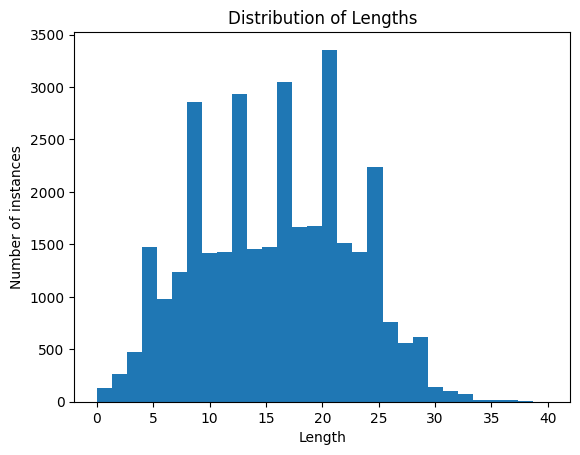

In [25]:
length = [len(token) for token in x_train]
print(f'Maximum length of each instances: {max(length)}')

plt.hist(length, bins=30)
plt.xlabel('Length')
plt.ylabel('Number of instances')
plt.title('Distribution of Lengths')
plt.show()

## Instruction to download GoogleNews word2vec pretrain weights

Kindly go through the following steps-

1. Download the [googlenews-vectors-negative300.bin.gz](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g)
2. Copy the file and paste it in the current working directory.


#### Word2Vec Pretrain Model

In [26]:
zip_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(zip_path, binary=True) 

#### Applying word2vec in sentence token [matrix_size = (token_number* 300)]

In [27]:
def vectorize_sentence(sentence, model):
    vectors = []
    for word in sentence:
        if word in model:
            vectors.append(model[word])
    return vectors

x_train = x_train.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))
x_test = x_test.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))
x_val= x_val.apply(lambda tokens: vectorize_sentence(tokens, word2vec_model))

In [28]:
# each vector size = len(x_train[index]) * 300

x_train[3]

[array([-0.18164062,  0.16503906, -0.16601562,  0.35742188, -0.09228516,
         0.20117188, -0.0546875 , -0.26171875, -0.17285156, -0.08056641,
         0.14648438, -0.24609375,  0.18652344,  0.10253906, -0.3203125 ,
         0.16699219, -0.0032196 , -0.06640625,  0.06591797, -0.109375  ,
         0.13964844, -0.05029297,  0.25390625,  0.0859375 ,  0.02026367,
         0.05517578, -0.08447266,  0.07324219,  0.15429688, -0.13867188,
        -0.25195312, -0.15136719,  0.07958984,  0.00848389, -0.24902344,
         0.05224609,  0.04394531, -0.19726562, -0.2109375 ,  0.01477051,
        -0.23632812, -0.14355469,  0.17773438,  0.26757812, -0.08789062,
        -0.07910156, -0.16113281,  0.23632812, -0.07177734,  0.08837891,
         0.07177734, -0.11962891, -0.09228516, -0.12060547, -0.00448608,
        -0.21875   , -0.05712891, -0.04418945,  0.07226562, -0.05883789,
        -0.12597656,  0.03125   , -0.24609375,  0.19140625,  0.14941406,
        -0.19335938, -0.1875    , -0.05126953,  0.0

In [29]:
def vector_lengths(data):
    vec_len = {}
    for vec in data:
        if len(vec) not in vec_len:
            vec_len[len(vec)] = 1
        else:
            vec_len[len(vec)] += 1

    return vec_len

In [30]:
print(f'Train: {vector_lengths(x_train)}')
print(f'Validation: {vector_lengths(x_val)}')
print(f'Test: {vector_lengths(x_test)}')

Train: {12: 1488, 8: 1481, 11: 1492, 6: 1131, 16: 1567, 4: 772, 15: 1573, 10: 1481, 17: 1678, 19: 1712, 18: 1793, 14: 1516, 3: 530, 26: 555, 5: 972, 23: 1198, 20: 1793, 13: 1477, 28: 224, 22: 1439, 9: 1454, 7: 1357, 25: 799, 21: 1622, 24: 1047, 27: 392, 2: 310, 1: 116, 32: 32, 29: 138, 30: 71, 31: 47, 34: 11, 0: 51, 33: 8, 36: 3, 35: 6}
Validation: {148: 15, 21: 10, 108: 30, 122: 29, 101: 38, 133: 34, 128: 33, 103: 34, 169: 2, 112: 29, 31: 15, 41: 30, 137: 33, 60: 28, 76: 25, 29: 15, 120: 25, 86: 34, 154: 17, 74: 30, 119: 30, 48: 31, 68: 24, 89: 31, 144: 18, 102: 33, 141: 24, 23: 15, 113: 28, 80: 32, 71: 27, 50: 29, 47: 30, 44: 26, 85: 29, 96: 36, 97: 28, 146: 19, 19: 12, 181: 4, 94: 30, 98: 35, 114: 30, 38: 31, 149: 17, 66: 28, 90: 27, 62: 27, 75: 28, 61: 34, 126: 28, 40: 32, 138: 18, 77: 32, 134: 28, 151: 11, 49: 24, 93: 25, 117: 31, 8: 6, 105: 39, 127: 20, 27: 24, 129: 17, 42: 26, 88: 21, 26: 14, 136: 30, 87: 26, 12: 10, 123: 31, 64: 23, 81: 37, 121: 31, 139: 18, 72: 30, 153: 6, 52:

### Padding the sentences

In [31]:
train_max_len = max(vector_lengths(x_train))
val_max_len = max(vector_lengths(x_val))
test_max_len = max(vector_lengths(x_test))

def pad_sequence(sequence, max_len):
    if len(sequence) < max_len:
        padding = [np.zeros(300)] * (max_len - len(sequence))
        return sequence + padding
    
    return sequence

x_train = x_train.apply(lambda x: pad_sequence(x, train_max_len))
x_val = x_val.apply(lambda x: pad_sequence(x, val_max_len))
x_test = x_test.apply(lambda x: pad_sequence(x, test_max_len))

### Convert to Tensor

In [32]:
print(x_train.dtypes)
print(y_train.dtypes)

object
float64


In [33]:
print(f'Train: {vector_lengths(x_train)}')
print(f'Validation: {vector_lengths(x_val)}')
print(f'Test: {vector_lengths(x_test)}')

Train: {36: 33336}
Validation: {184: 3705}
Test: {36: 4116}


In [34]:
x_train_tensor = torch.tensor(x_train.tolist(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.long)
x_val_tensor = torch.tensor(x_val.tolist(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.tolist(), dtype=torch.long)
x_test_tensor = torch.tensor(x_test.tolist(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

C:\Users\tasnu\AppData\Local\Temp\ipykernel_8512\2376048147.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_train_tensor = torch.tensor(x_train.tolist(), dtype=torch.float32)


In [35]:
print(x_train_tensor.size())
print(x_val_tensor.size())
print(x_test_tensor.size())

torch.Size([33336, 36, 300])
torch.Size([3705, 184, 300])
torch.Size([4116, 36, 300])


In [36]:
print(y_train_tensor.unique())
print(y_val_tensor.unique())
print(y_test_tensor.unique())

tensor([0, 1, 0,  ..., 2, 3, 0])
tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 3, 4])


### LSTM Model

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = 0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [38]:
def calculate_accuracy(y_pred, y_true):
    y_pred_tag = torch.argmax(y_pred, dim=1)
    correct_results_sum = (y_pred_tag == y_true).sum().float()
    acc = correct_results_sum / y_true.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [39]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 2

model = LSTMModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [40]:
train_losses = []
val_losses = []
test_losses = []

train_accuracy = []
val_accuracy = []
test_accuracy = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0

    test_acc = 0
    test_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs, batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_outputs = model(batch_x)
            test_loss += loss_function(test_outputs, batch_y).item()
            test_acc += calculate_accuracy(test_outputs, batch_y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/10
Train Loss: 1.4412, Train Accuracy: 33.60%
Validation Loss: 3.0146, Validation Accuracy: 19.78%
Test Loss: 3.0146, Test Accuracy: 19.78%
Epoch 2/10
Train Loss: 1.3449, Train Accuracy: 38.64%
Validation Loss: 3.3515, Validation Accuracy: 19.78%
Test Loss: 3.3515, Test Accuracy: 19.78%
Epoch 3/10
Train Loss: 1.2978, Train Accuracy: 41.87%
Validation Loss: 3.2366, Validation Accuracy: 19.78%
Test Loss: 3.2366, Test Accuracy: 19.78%
Epoch 4/10
Train Loss: 1.1327, Train Accuracy: 52.44%
Validation Loss: 3.2758, Validation Accuracy: 21.13%
Test Loss: 3.2758, Test Accuracy: 21.13%
Epoch 5/10
Train Loss: 1.0409, Train Accuracy: 57.00%
Validation Loss: 3.6392, Validation Accuracy: 19.78%
Test Loss: 3.6392, Test Accuracy: 19.78%
Epoch 6/10
Train Loss: 0.9990, Train Accuracy: 58.74%
Validation Loss: 3.7695, Validation Accuracy: 19.78%
Test Loss: 3.7695, Test Accuracy: 19.78%
Epoch 7/10
Train Loss: 0.9654, Train Accuracy: 60.38%
Validation Loss: 3.8519, Validation Accuracy: 19.78%
Test 

In [41]:
lstm_train_accuracy = max(train_accuracy)
lstm_val_accuracy = max(val_accuracy)
lstm_test_accuracy = max(test_accuracy)

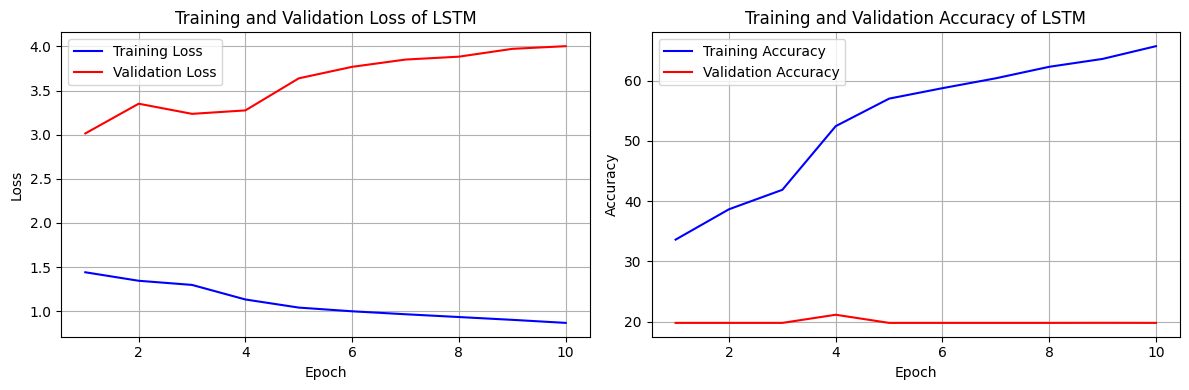

In [42]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of LSTM')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of LSTM')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### GRU Model

In [43]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [44]:
input_size = 300
hidden_size = 128
output_size = 5
num_layers = 1

model = GRUModel(input_size, hidden_size, output_size, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

C:\Users\tasnu\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [45]:
train_losses = []
val_losses = []
test_losses = []

train_accuracy = []
val_accuracy = []
test_accuracy = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += calculate_accuracy(outputs, batch_y)
    
    model.eval()
    val_loss = 0
    val_acc = 0

    test_acc = 0
    test_loss = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            val_outputs = model(batch_x)
            val_loss += loss_function(val_outputs, batch_y).item()
            val_acc += calculate_accuracy(val_outputs, batch_y)

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            test_outputs = model(batch_x)
            test_loss += loss_function(test_outputs, batch_y).item()
            test_acc += calculate_accuracy(test_outputs, batch_y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    test_losses.append(test_loss)
    test_accuracy.append(test_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

Epoch 1/10
Train Loss: 1.5647, Train Accuracy: 28.16%
Validation Loss: 2.0242, Validation Accuracy: 21.16%
Test Loss: 2.0242, Test Accuracy: 21.16%
Epoch 2/10
Train Loss: 1.3465, Train Accuracy: 40.54%
Validation Loss: 2.3579, Validation Accuracy: 25.77%
Test Loss: 2.3579, Test Accuracy: 25.77%
Epoch 3/10
Train Loss: 1.0875, Train Accuracy: 54.77%
Validation Loss: 2.9822, Validation Accuracy: 25.88%
Test Loss: 2.9822, Test Accuracy: 25.88%
Epoch 4/10
Train Loss: 0.9991, Train Accuracy: 58.57%
Validation Loss: 3.2211, Validation Accuracy: 24.24%
Test Loss: 3.2211, Test Accuracy: 24.24%
Epoch 5/10
Train Loss: 0.9555, Train Accuracy: 60.76%
Validation Loss: 3.3872, Validation Accuracy: 23.12%
Test Loss: 3.3872, Test Accuracy: 23.12%
Epoch 6/10
Train Loss: 0.9256, Train Accuracy: 62.72%
Validation Loss: 3.4859, Validation Accuracy: 21.73%
Test Loss: 3.4859, Test Accuracy: 21.73%
Epoch 7/10
Train Loss: 0.8995, Train Accuracy: 63.97%
Validation Loss: 3.3118, Validation Accuracy: 24.22%
Test 

In [46]:
gru_train_accuracy = max(train_accuracy)
gru_val_accuracy = max(val_accuracy)
gru_test_accuracy = max(test_accuracy)

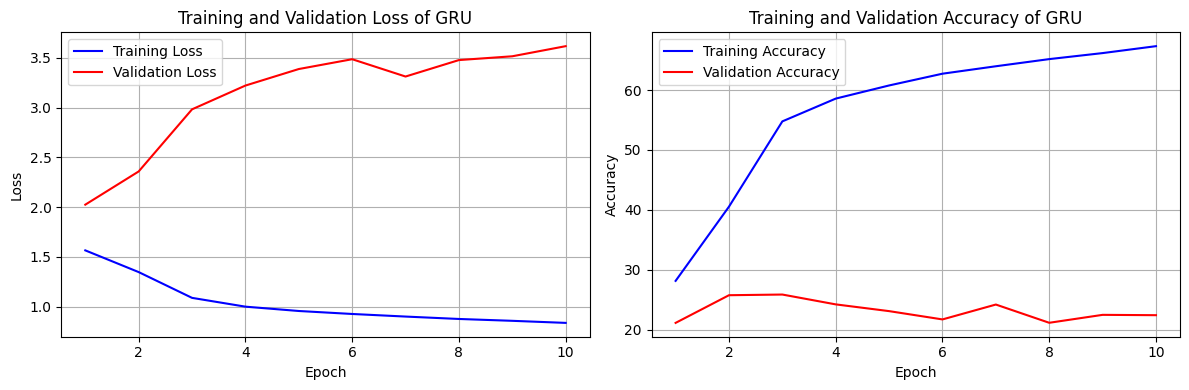

In [47]:
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of GRU')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of GRU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Comapre the models

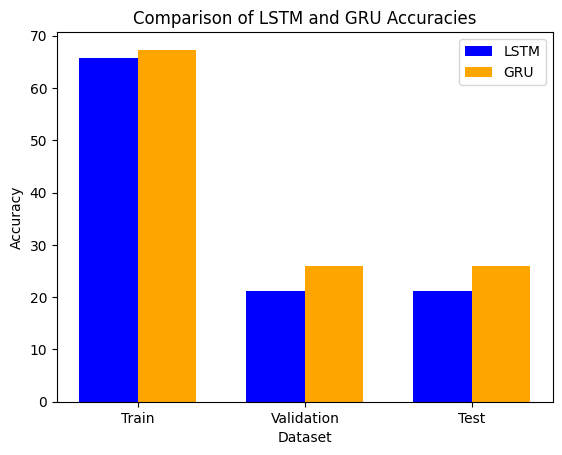

In [48]:
labels = ['Train', 'Validation', 'Test']
lstm_accuracies = [lstm_train_accuracy, lstm_val_accuracy, lstm_test_accuracy]
gru_accuracies = [gru_train_accuracy, gru_val_accuracy, gru_test_accuracy]

bar_width = 0.35
index = range(len(labels))

plt.bar(index, lstm_accuracies, bar_width, label='LSTM', color='blue')
plt.bar([i + bar_width for i in index], gru_accuracies, bar_width, label='GRU', color='orange')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Comparison of LSTM and GRU Accuracies')
plt.xticks([i + bar_width / 2 for i in index], labels)

plt.legend()
plt.show()